# Deep Prior Distribution of Relaxation Times

## In this tutorial we will reproduce Figure 2 in
## Liu, J., & Ciucci, F. (2020). The Deep-Prior Distribution of Relaxation Times. Journal of The Electrochemical Society, 167(2), 026506
## https://iopscience.iop.org/article/10.1149/1945-7111/ab631a/meta

The DP-DRT method is our next newly developed deep learning based approach to obtain the DRT from the EIS data. The DP-DRT is trained on a single electrochemical impedance spectrum. A single random input is given to the nerural network underlying the DP-DRT. 

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import random as rnd
import math
from math import sin, cos, pi
import torch
import torch.nn.functional as F
import compute_DRT
%matplotlib inline

# check the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,1), 'MB')
    
# we will assume you have a cpu 
#if you want to use a GPU, you will need to use cuda

Using device: cpu


## 1) Problem setup
### 1.1) Generate a single stochastic experiment 
### note: the exact circuit is a ZARC

The impedance of a ZARC can be written as
$$
Z^{\rm exact}(f) = R_\infty + \displaystyle \frac{1}{\displaystyle \frac{1}{R_{\rm ct}}+C \left(i 2\pi f\right)^\phi}
$$

where $\displaystyle C = \frac{\tau_0^\phi}{R_{\rm ct}}$.

The analytical DRT can be computed analytically as

$$
\gamma(\log \tau) =  \displaystyle \frac{\displaystyle R_{\rm ct}}{\displaystyle 2\pi} \displaystyle \frac{\displaystyle \sin\left((1-\phi)\pi\right)}{\displaystyle \cosh(\phi \log(\tau/\tau_0))-\cos(\pi(1-\phi))}
$$

In [3]:
# set the seed for the random number generators
rng = rnd.seed(214975)
rng_np = np.random.seed(213912)
torch.manual_seed(213912)

# define frequency range, from 1E-4 to 1E4 with 10 ppd
N_freqs = 81
freq_vec = np.logspace(-4., 4., num=N_freqs, endpoint=True)
tau_vec  = 1./freq_vec

# define parameters for ZARC model and calculate the impedance and gamma following the above equations
R_inf = 10
R_ct = 50
phi = 0.8
tau_0 = 1
C = tau_0**phi/R_ct

# exact Z and gamma
Z = R_inf + 1./(1./R_ct+C*(1j*2.*pi*freq_vec)**phi)
gamma_exact = (R_ct)/(2.*pi)*sin((1.-phi)*pi)/(np.cosh(phi*np.log(tau_vec/tau_0))-cos((1.-phi)*pi))

# adding noise to the impedance data
sigma_n_exp = 0.1
Z_exp = Z + sigma_n_exp*(np.random.normal(0,1,N_freqs) + 1j*np.random.normal(0,1,N_freqs))

### 1.2) Build $\mathbf A_{\rm re}$ and $\mathbf A_{\rm im}$ matrices

In [5]:
# define the matrices that calculate the impedace from DRT, i.e., Z_re = A_re * gamma, Z_im = A_im * gamma
A_re = compute_DRT.A_re(freq_vec)
A_im = compute_DRT.A_im(freq_vec)

### 1.3) Take vectors and matrices from numpy to torch

In [6]:
# transform impedance variables to tensors
Z_exp_re_torch = torch.from_numpy(np.real(Z_exp)).type(torch.FloatTensor).reshape(1,N_freqs)
Z_exp_im_torch = torch.from_numpy(np.imag(Z_exp)).type(torch.FloatTensor).reshape(1,N_freqs)
# tranform gamma
gamma_exact_torch = torch.from_numpy(gamma_exact).type(torch.FloatTensor)

# transform these matrices into tensors
A_re_torch = torch.from_numpy(A_re.T).type(torch.FloatTensor)
A_im_torch = torch.from_numpy(A_im.T).type(torch.FloatTensor)

## 2) Setup DP-DRT model
### 2.1) Deep network

In [7]:
# size of the arbitrary zeta input
N_zeta = 1

# define the neural network
# N is batch size, D_in is input dimension, H is hidden dimension, D_out is output dimension.
N = 1
D_in = N_zeta
H = max(N_freqs,10*N_zeta)
# the output also includes the R_inf, so it has dimension N_freq+1
# note that 
# 1) there is no inductance (in this specific example - the DP-DRT can include inductive features, see article)
# 2) R_inf is stored as the last item in the NN output

D_out = N_freqs+1

# Construct the neural network structure
class vanilla_model(torch.nn.Module):
    def __init__(self):
        super(vanilla_model, self).__init__()
        self.fct_1 = torch.nn.Linear(D_in, H)
        self.fct_2 = torch.nn.Linear(H, H) 
        self.fct_3 = torch.nn.Linear(H, H)
        self.fct_4 = torch.nn.Linear(H, D_out) 
        
        # initialize the weight parameters
        torch.nn.init.zeros_(self.fct_1.weight)
        torch.nn.init.zeros_(self.fct_2.weight)
        torch.nn.init.zeros_(self.fct_3.weight)
        torch.nn.init.zeros_(self.fct_4.weight)
    
    # forward
    def forward(self, zeta):
        h = F.elu(self.fct_1(zeta))
        h = F.elu(self.fct_2(h))
        h = F.elu(self.fct_3(h))
        gamma_pred = F.softplus(self.fct_4(h), beta = 5)        
        
        return gamma_pred

###  2.2) Loss function

In [8]:
def loss_fn(output, Z_exp_re_torch, Z_exp_im_torch, A_re_torch, A_im_torch):
    
    # we assume no inductance and the R_inf is stored as the last item in the NN output

    MSE_re = torch.sum((output[:, -1] + torch.mm(output[:, 0:-1], A_re_torch) - Z_exp_re_torch)**2)
    MSE_im = torch.sum((torch.mm(output[:, 0:-1], A_im_torch) - Z_exp_im_torch)**2)
    MSE = MSE_re + MSE_im
    
    return MSE

## 3) Train the model

In [6]:
model = vanilla_model()

# initialize following variables 
zeta = torch.randn(N, N_zeta)
loss_vec = np.array([])
distance_vec = np.array([])
lambda_vec = np.array([])

# optimize the neural network
learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# max iterations
max_iters = 100001
gamma_NN_store = torch.zeros((max_iters, N_freqs))
R_inf_NN_store = torch.zeros((max_iters, 1))

for t in range(max_iters):
    # Forward pass: compute predicted y by passing x to the model.
    gamma = model(zeta)
    
    # Compute the loss
    loss = loss_fn(gamma, Z_exp_re_torch, Z_exp_im_torch, A_re_torch, A_im_torch)
    # save it
    loss_vec = np.append(loss_vec, loss.item())
    
    # store gamma
    gamma_NN = gamma[:, 0:-1].detach().reshape(-1) 
    gamma_NN_store[t, :] = gamma_NN
    
    # store R_inf
    R_inf_NN_store[t,:] = gamma[:, -1].detach().reshape(-1)

    # Compute the distance
    distance = math.sqrt(torch.sum((gamma_NN-gamma_exact_torch)**2).item()) 
    # save it
    distance_vec = np.append(distance_vec, distance)

    # and print it
    if not t%100:
        print('iter=', t, '; loss=', loss.item(), '; distance=', distance)
    
    # zero all gradients (purge any cache)
    optimizer.zero_grad()
    
    # compute the gradient of the loss with respect to model parameters
    loss.backward()

    # Update the optimizer
    optimizer.step()

iter= 0 ; loss= 108280.3203125 ; distance= 54.83923369937234
iter= 100 ; loss= 108098.078125 ; distance= 54.82739695655129
iter= 200 ; loss= 107681.28125 ; distance= 54.80032557926778
iter= 300 ; loss= 106687.40625 ; distance= 54.73580901989574
iter= 400 ; loss= 104597.9375 ; distance= 54.6002920736808
iter= 500 ; loss= 100640.1796875 ; distance= 54.34389151433558
iter= 600 ; loss= 93995.84375 ; distance= 53.914215896934365
iter= 700 ; loss= 84615.265625 ; distance= 53.31095213169148
iter= 800 ; loss= 73558.4453125 ; distance= 52.60951653901364
iter= 900 ; loss= 62076.08203125 ; distance= 51.898792077856925
iter= 1000 ; loss= 51006.81640625 ; distance= 51.23900892051143
iter= 1100 ; loss= 40869.55078125 ; distance= 50.666478474585396
iter= 1200 ; loss= 32011.671875 ; distance= 50.201366974353896
iter= 1300 ; loss= 24650.890625 ; distance= 49.84826831009905
iter= 1400 ; loss= 18868.6640625 ; distance= 49.5953843461012
iter= 1500 ; loss= 14603.1435546875 ; distance= 49.41785373301966
ite

iter= 12400 ; loss= 8.309840202331543 ; distance= 15.75144394810188
iter= 12500 ; loss= 7.639482498168945 ; distance= 15.573096409741686
iter= 12600 ; loss= 7.023601531982422 ; distance= 15.398174405572046
iter= 12700 ; loss= 6.457856178283691 ; distance= 15.226648681772526
iter= 12800 ; loss= 5.9400177001953125 ; distance= 15.058610975995336
iter= 12900 ; loss= 5.468051910400391 ; distance= 14.894078433649238
iter= 13000 ; loss= 5.038852691650391 ; distance= 14.73290852988642
iter= 13100 ; loss= 4.6480512619018555 ; distance= 14.57491549275994
iter= 13200 ; loss= 4.291302680969238 ; distance= 14.419929679032494
iter= 13300 ; loss= 3.964749813079834 ; distance= 14.267821829070257
iter= 13400 ; loss= 3.66526198387146 ; distance= 14.118456920133449
iter= 13500 ; loss= 3.390367031097412 ; distance= 13.97167610397181
iter= 13600 ; loss= 3.1379361152648926 ; distance= 13.827308415154864
iter= 13700 ; loss= 2.906085968017578 ; distance= 13.685189944904858
iter= 13800 ; loss= 2.69309735298156

iter= 24200 ; loss= 0.020254146307706833 ; distance= 5.679344282313829
iter= 24300 ; loss= 0.020262181758880615 ; distance= 5.661295458273587
iter= 24400 ; loss= 0.019968334585428238 ; distance= 5.643782558748572
iter= 24500 ; loss= 0.01987108588218689 ; distance= 5.626935837681706
iter= 24600 ; loss= 0.01981179416179657 ; distance= 5.610166871008085
iter= 24700 ; loss= 0.019707687199115753 ; distance= 5.593832175221296
iter= 24800 ; loss= 0.019674401730298996 ; distance= 5.577817593179541
iter= 24900 ; loss= 0.01953798532485962 ; distance= 5.5624065605630735
iter= 25000 ; loss= 0.019506238400936127 ; distance= 5.546975406221535
iter= 25100 ; loss= 0.019578494131565094 ; distance= 5.532064259396557
iter= 25200 ; loss= 0.01955997198820114 ; distance= 5.51743691052698
iter= 25300 ; loss= 0.019228115677833557 ; distance= 5.503128375821917
iter= 25400 ; loss= 0.01916634663939476 ; distance= 5.489154352537506
iter= 25500 ; loss= 0.019105155020952225 ; distance= 5.475355943231282
iter= 25600

iter= 35900 ; loss= 0.016906043514609337 ; distance= 4.759935528615095
iter= 36000 ; loss= 0.016895093023777008 ; distance= 4.756197450124449
iter= 36100 ; loss= 0.016889221966266632 ; distance= 4.75257944039658
iter= 36200 ; loss= 0.01697821542620659 ; distance= 4.74887854739261
iter= 36300 ; loss= 0.016980303451418877 ; distance= 4.745353433773483
iter= 36400 ; loss= 0.016872979700565338 ; distance= 4.741745251013882
iter= 36500 ; loss= 0.016868576407432556 ; distance= 4.738204565473346
iter= 36600 ; loss= 0.016861997544765472 ; distance= 4.7346610307057455
iter= 36700 ; loss= 0.016883283853530884 ; distance= 4.731126331643111
iter= 36800 ; loss= 0.016900047659873962 ; distance= 4.727692070281372
iter= 36900 ; loss= 0.017082950100302696 ; distance= 4.724269039390429
iter= 37000 ; loss= 0.016843967139720917 ; distance= 4.7207677708130555
iter= 37100 ; loss= 0.016898557543754578 ; distance= 4.717368220443057
iter= 37200 ; loss= 0.016844362020492554 ; distance= 4.713952259144047
iter= 3

iter= 47500 ; loss= 0.01658587157726288 ; distance= 4.457718471066242
iter= 47600 ; loss= 0.016589777544140816 ; distance= 4.455834778946646
iter= 47700 ; loss= 0.016576241701841354 ; distance= 4.453956499604168
iter= 47800 ; loss= 0.01657087355852127 ; distance= 4.45209263663896
iter= 47900 ; loss= 0.016568820923566818 ; distance= 4.450259066123593
iter= 48000 ; loss= 0.01657673716545105 ; distance= 4.448423882300459
iter= 48100 ; loss= 0.016604745760560036 ; distance= 4.446643274828128
iter= 48200 ; loss= 0.01656464859843254 ; distance= 4.44484822240477
iter= 48300 ; loss= 0.016610365360975266 ; distance= 4.443068328380096
iter= 48400 ; loss= 0.01656712219119072 ; distance= 4.44121277990831
iter= 48500 ; loss= 0.01659223809838295 ; distance= 4.4393929755604065
iter= 48600 ; loss= 0.0165614802390337 ; distance= 4.437608744403702
iter= 48700 ; loss= 0.016565416008234024 ; distance= 4.435889368175714
iter= 48800 ; loss= 0.01655917800962925 ; distance= 4.4341861009855945
iter= 48900 ; lo

iter= 59200 ; loss= 0.01651846244931221 ; distance= 4.2838240633045
iter= 59300 ; loss= 0.016519371420145035 ; distance= 4.28270345922733
iter= 59400 ; loss= 0.01660563237965107 ; distance= 4.28153712291365
iter= 59500 ; loss= 0.016484137624502182 ; distance= 4.280265527848898
iter= 59600 ; loss= 0.016500065103173256 ; distance= 4.279131288515297
iter= 59700 ; loss= 0.016515182331204414 ; distance= 4.277960188528382
iter= 59800 ; loss= 0.016642391681671143 ; distance= 4.276659878621075
iter= 59900 ; loss= 0.016587473452091217 ; distance= 4.275622825538362
iter= 60000 ; loss= 0.01661519519984722 ; distance= 4.274323812625312
iter= 60100 ; loss= 0.016466796398162842 ; distance= 4.2732245969303495
iter= 60200 ; loss= 0.01647309586405754 ; distance= 4.272034688558723
iter= 60300 ; loss= 0.016530625522136688 ; distance= 4.270853380605896
iter= 60400 ; loss= 0.01662250980734825 ; distance= 4.269809333421624
iter= 60500 ; loss= 0.016490384936332703 ; distance= 4.268565970122071
iter= 60600 ; 

iter= 70900 ; loss= 0.01641843467950821 ; distance= 4.168027325033578
iter= 71000 ; loss= 0.0167439766228199 ; distance= 4.167317047222387
iter= 71100 ; loss= 0.01641797460615635 ; distance= 4.166412320321262
iter= 71200 ; loss= 0.016418438404798508 ; distance= 4.165614084170807
iter= 71300 ; loss= 0.01641605608165264 ; distance= 4.164777454599212
iter= 71400 ; loss= 0.01641552522778511 ; distance= 4.16399883056976
iter= 71500 ; loss= 0.01651918888092041 ; distance= 4.163129118611089
iter= 71600 ; loss= 0.016543004661798477 ; distance= 4.162445727845093
iter= 71700 ; loss= 0.01666882075369358 ; distance= 4.161663917680127
iter= 71800 ; loss= 0.016518842428922653 ; distance= 4.1607164748962
iter= 71900 ; loss= 0.016498073935508728 ; distance= 4.159925628144024
iter= 72000 ; loss= 0.01647103764116764 ; distance= 4.159132338050801
iter= 72100 ; loss= 0.01666080951690674 ; distance= 4.158290734897874
iter= 72200 ; loss= 0.01706511154770851 ; distance= 4.157443456030147
iter= 72300 ; loss= 

iter= 82600 ; loss= 0.016419047489762306 ; distance= 4.086077773419709
iter= 82700 ; loss= 0.016553256660699844 ; distance= 4.085579442515286
iter= 82800 ; loss= 0.016395937651395798 ; distance= 4.084923000100252
iter= 82900 ; loss= 0.01650511845946312 ; distance= 4.084212279927399
iter= 83000 ; loss= 0.016376402229070663 ; distance= 4.083661176534646
iter= 83100 ; loss= 0.01637544296681881 ; distance= 4.083070058833999
iter= 83200 ; loss= 0.016402985900640488 ; distance= 4.0824975436425746
iter= 83300 ; loss= 0.016398675739765167 ; distance= 4.081889202073938
iter= 83400 ; loss= 0.016381481662392616 ; distance= 4.081262777171208
iter= 83500 ; loss= 0.01638982817530632 ; distance= 4.080623635893477
iter= 83600 ; loss= 0.016613967716693878 ; distance= 4.079951202624352
iter= 83700 ; loss= 0.016555797308683395 ; distance= 4.07952365787312
iter= 83800 ; loss= 0.016373950988054276 ; distance= 4.0788592265892225
iter= 83900 ; loss= 0.01638012006878853 ; distance= 4.078272089735436
iter= 840

iter= 94300 ; loss= 0.016347229480743408 ; distance= 4.021581128935649
iter= 94400 ; loss= 0.016347628086805344 ; distance= 4.021092829788485
iter= 94500 ; loss= 0.016347695142030716 ; distance= 4.02061467078513
iter= 94600 ; loss= 0.016342274844646454 ; distance= 4.020136929357772
iter= 94700 ; loss= 0.016350775957107544 ; distance= 4.019680958324163
iter= 94800 ; loss= 0.016355333849787712 ; distance= 4.0192076142184305
iter= 94900 ; loss= 0.01643349975347519 ; distance= 4.018770522188318
iter= 95000 ; loss= 0.016341302543878555 ; distance= 4.018247467942094
iter= 95100 ; loss= 0.016343077644705772 ; distance= 4.017776803318495
iter= 95200 ; loss= 0.01634451374411583 ; distance= 4.0172956383126035
iter= 95300 ; loss= 0.016345907002687454 ; distance= 4.01681987633816
iter= 95400 ; loss= 0.01633978821337223 ; distance= 4.016378250425161
iter= 95500 ; loss= 0.016357405111193657 ; distance= 4.015931589022647
iter= 95600 ; loss= 0.016424916684627533 ; distance= 4.01548250294349
iter= 9570

## 4) Analyze results
### 4.1) Find early stopping value

In [7]:
index_opt = np.argmin(distance_vec)    
index_early_stop = np.flatnonzero(np.abs(np.diff(loss_vec))<1E-8)

gamma_DIP_torch_opt = gamma_NN_store[index_opt, :]
R_inf_DIP_torch_opt = R_inf_NN_store[index_opt, :]

gamma_DIP_opt = gamma_DIP_torch_opt.detach().numpy()
R_DIP_opt = R_inf_DIP_torch_opt.detach().numpy()

if len(index_early_stop):
    gamma_DIP_torch_early_stop = gamma_NN_store[index_early_stop[0], :]
    gamma_DIP = gamma_DIP_torch_early_stop.detach().numpy()
    R_DIP = R_inf_NN_store[index_early_stop[0], :]
    R_DIP = R_DIP.detach().numpy()
else:
    gamma_DIP = gamma_DIP_opt
    R_DIP = R_DIP_opt

### 4.2) Plot the loss

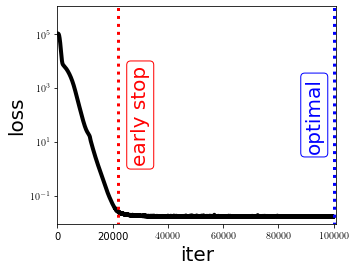

In [8]:
plt.semilogy(loss_vec, linewidth=4, color="black")
plt.semilogy(np.array([index_early_stop[0], index_early_stop[0]]), np.array([1E-3, 1E7]), 
              ':', linewidth=3, color="red")
plt.semilogy(np.array([index_opt, index_opt]), np.array([1E-3, 1E7]), 
              ':', linewidth=3, color="blue")
plt.text(30000, 1E2, r'early stop', 
         {'color': 'red', 'fontsize': 20, 'ha': 'center', 'va': 'center', 
          'rotation': 90, 
          'bbox': dict(boxstyle="round", fc="white", ec="red", pad=0.2)})
plt.text(0.93E5, 1E2, r'optimal', 
         {'color': 'blue', 'fontsize': 20, 'ha': 'center', 'va': 'center', 
          'rotation': 90, 
          'bbox': dict(boxstyle="round", fc="white", ec="blue", pad=0.2)})
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel(r'iter', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.axis([0,1.01E5,0.9E-2,1.1E6])
fig = plt.gcf()
fig.set_size_inches(5, 4)
plt.show()

### 4.3) Plot the error curve vs. iteration
The error is defined as the distance between predicted DRT and exact DRT, i.e.,$ \rm error = ||\mathbf \gamma_{\rm exact} - \mathbf \gamma_{\rm DP-DRT}||$

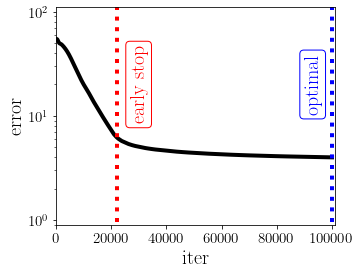

In [9]:
plt.semilogy(distance_vec, linewidth=4, color="black")
plt.semilogy(np.array([index_early_stop[0], index_early_stop[0]]), np.array([1E-3, 1E7]), 
              ':', linewidth=4, color="red")
plt.semilogy(np.array([index_opt, index_opt]), np.array([1E-3, 1E7]), 
              ':', linewidth=4, color="blue")
plt.text(30000, 2E1, r'early stop', 
         {'color': 'red', 'fontsize': 20, 'ha': 'center', 'va': 'center', 
          'rotation': 90, 
          'bbox': dict(boxstyle="round", fc="white", ec="red", pad=0.2)})
plt.text(0.93E5, 2E1, r'optimal', 
         {'color': 'blue', 'fontsize': 20, 'ha': 'center', 'va': 'center', 
          'rotation': 90, 
          'bbox': dict(boxstyle="round", fc="white", ec="blue", pad=0.2)})
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel(r'iter', fontsize=20)
plt.ylabel(r'error', fontsize=20)
plt.axis([0,1.01E5,0.9E0,1.1E2])
fig=plt.gcf()
fig.set_size_inches(5, 4)
plt.show()

### 4.4) Plot the impedance
We compare the DP-DRT EIS spectrum against the one from the stochastic experiment

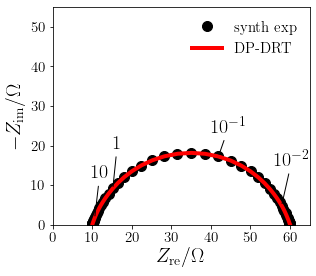

In [10]:
Z_DIP = R_DIP + np.matmul(A_re, gamma_DIP) + 1j*np.matmul(A_im, gamma_DIP)

plt.plot(np.real(Z_exp), -np.imag(Z_exp), "o", markersize=10, color="black", label="synth exp")
plt.plot(np.real(Z_DIP), -np.imag(Z_DIP), linewidth=4, color="red", label="DP-DRT")
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=20)
plt.annotate(r'$10^{-2}$', xy=(np.real(Z_exp[20]), -np.imag(Z_exp[20])), 
             xytext=(np.real(Z_exp[20])-2, 10-np.imag(Z_exp[20])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10^{-1}$', xy=(np.real(Z_exp[30]), -np.imag(Z_exp[30])), 
             xytext=(np.real(Z_exp[30])-2, 6-np.imag(Z_exp[30])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$1$', xy=(np.real(Z_exp[40]), -np.imag(Z_exp[40])), 
             xytext=(np.real(Z_exp[40]), 10-np.imag(Z_exp[40])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.annotate(r'$10$', xy=(np.real(Z_exp[50]), -np.imag(Z_exp[50])), 
             xytext=(np.real(Z_exp[50])-1, 10-np.imag(Z_exp[50])), 
             arrowprops=dict(arrowstyle="-",connectionstyle="arc"))
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.legend(frameon=False, fontsize = 15)
plt.xlim(10, 65)
plt.ylim(0, 55)
plt.xticks(range(0, 70, 10))
plt.yticks(range(0, 60, 10))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
fig = plt.gcf()
size = fig.get_size_inches()
plt.show()

### 4.5) Plot the DRT
We compare the $\gamma$ from the DP-DRT model against the exact one

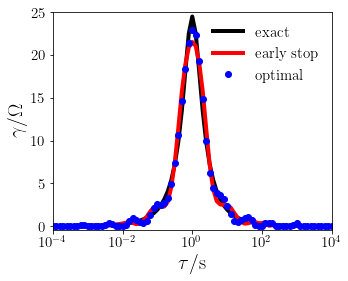

In [11]:
plt.semilogx(tau_vec, gamma_exact, linewidth=4, color="black", label="exact")
plt.semilogx(tau_vec, gamma_DIP, linewidth=4, color="red", label="early stop")
plt.semilogx(tau_vec, gamma_DIP_opt, linestyle='None', marker='o', color="blue", label="optimal")
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.axis([1E-4,1E4,-0.4,25])
plt.legend(frameon=False, fontsize = 15)
plt.xlabel(r'$\tau/{\rm s}$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
fig = plt.gcf()
fig.set_size_inches(5, 4)
plt.show()

### 4.6) Ancillary data

In [12]:
print('total number parameters = ', compute_DRT.count_parameters(model))
print('distance_early_stop = ', distance_vec[index_early_stop[0]])
print('distance_opt= ', distance_vec[index_opt])

total number parameters =  20170
distance_early_stop =  6.249378631221442
distance_opt=  3.9961969655001686
